In [ ]:
'''
Prepared By:
Alemu Sisay Nigru, October 2021
'''

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import random
from PIL import Image
import math
from scipy import ndimage


In [ ]:
import os
from google.colab import drive

drive.mount("/content/drive", force_remount=True)
data_path = "/content/drive/My Drive/DIP Project/Images"

Mounted at /content/drive


# Display Image

In [ ]:
def show_image(image, title):
    if(len(image.shape)==2):
        plt.imshow(image, cmap = 'gray', interpolation = 'bicubic', vmin=0, vmax=255)
    else:
        plt.imshow(image, interpolation = 'bicubic', vmin=0, vmax=255)
    
    plt.title(title)
    plt.xticks([]), plt.yticks([]) 
    plt.show()    


In [ ]:
#Generate a random image with a shape compatible to our watermark signature image size
def rand_key(width,height,key,a=256): 
  # Loop to find the string of desired length 
  for i in range(1,a): 
    random.seed(key)
    a = np.random.rand(width,height) * 255
    im_out = Image.fromarray(a.astype('uint8')).convert('RGB')
    gray_img=cv2.cvtColor(np.float32(im_out),cv2.COLOR_RGB2GRAY)
    ret, binary_rand =cv2.threshold( gray_img,150,255,cv2.THRESH_BINARY)
  return binary_rand

In [ ]:
def watermark_Xor(binary_watermark,Random_img):
  dest_xor = cv2.bitwise_xor(Random_img.astype(np.uint8), binary_watermark.astype(np.uint8), mask = None) 
  return dest_xor

In [ ]:
#Xoring
def xor_c(a, b): 
    return '0' if(a == b) else '1'; 

In [ ]:
#Applying Gray code to the W' image to get W"
def binarytoGray(binaryimage): 
    #width,height = image.shape
    gray = np.zeros(binaryimage.shape,dtype= np.uint8 )
 
    for i in range(0,binaryimage.shape[0]):
      # MSB of gray code is same as binary code 
      gray[i][0] = binaryimage[i][0] 
      # Compute remaining bits, next bit   is comuted by doing XOR of previous   and current in Binary 
      for j in range(1,binaryimage.shape[1]):
          gray[i][j] =   xor_c(binaryimage[i][j - 1], binaryimage[i][j]); 
          
    return gray*255; 

In [ ]:
#Applying gray code to binary conversion to get W' image from W"
def GraytoBinary(grayimage): 
    #width,height = image.shape
    binary = np.zeros(grayimage.shape,dtype= np.uint8 )
    for i in range(0,grayimage.shape[0]):
    # MSB of gray code is same as binary code 
      binary[i][0] = grayimage[i][0] 
      # Compute remaining bits, next bit   is comuted by doing XOR of previous   and current in Binary 
      for j in range(1,grayimage.shape[1]):
        binary[i][j] =   xor_c(binary[i][j - 1], grayimage[i][j]);
    return binary*255

In [ ]:
def normalized_cross_correlation(orig_Img,wtr_img):
  Cross_Corr = 0
  Normalizer = 0
  for i in range (0,orig_Img.shape[0]):
    for j in range (0,orig_Img.shape[1]):
      Cross_Corr += orig_Img[i,j]/255*wtr_img[i,j]/255
      Normalizer += np.power(orig_Img[i,j]/255,2)
  NCC = Cross_Corr/Normalizer
  return NCC    

In [ ]:
#EMBEDDING THE WATERMARK
def WaterMark_Embedding(Original,Watermark):
  Original_image = cv2.cvtColor(Original, cv2.COLOR_BGR2RGB)
  RC_image = np.zeros(Original_image.shape,dtype=np.uint8)
  GC_image = np.zeros(Original_image.shape,dtype=np.uint8)
  BC_image = np.zeros(Original_image.shape,dtype=np.uint8)
  RC_image[:,:,0] = Original_image[:,:,0]
  GC_image[:,:,1] = Original_image[:,:,1]
  BC_image[:,:,2] = Original_image[:,:,2]
  show_image(Original_image,"Original Without Watermark")  
  windowsize_r = 8
  windowsize_c = 8
  block = 0
  a = 0
  i1,j1,i2,j2,i3,j3,i4,j4,i5,j5 = 0,0,0,0,0,0,0,0,0,0
  fs = BC_image.shape[0]  # Full Section of the image size
  fqs = BC_image.shape[0]/4  #First quarter section of the image
  sqs = 3*BC_image.shape[0]/4   #Second quarter section of the image  
   #The B component is divided into a non-overlapping blocks with size of 8*8 pixels
  for r in range(0,fs, windowsize_r):
      for c in range(0,fs, windowsize_c):
        if (r < fqs):
          if (Watermark[i1,j1] == 255):
            a += 1
            # New 8x8 block of the blue component of the original image assigned to window
            BC_image[r:r+windowsize_r,c:c+windowsize_c,2] += 5
            block += 1
            j1 +=1
            if(j1 == 32):
              i1 += 1 
              j1 = 0            
          else:
            BC_image[r:r+windowsize_r,c:c+windowsize_c,2] -= 5
            block += 1
            a += 1
            j1 +=1
            if(j1 == 32):
              i1 += 1 
              j1 = 0                
        elif ( (r < sqs and r >= fqs and c < fqs) or (r < sqs and r >= fqs and c >= sqs)): #WM2 (half and half)
          if (Watermark[i2,j2] == 255):
            BC_image[r:r+windowsize_r,c:c+windowsize_c,2] += 5
            # New 8x8 block of the blue component of the original image assigned to window
            block += 1
            j2 +=1
            if(j2 == 32):
              i2 += 1 
              j2 = 0              
          else:
            BC_image[r:r+windowsize_r,c:c+windowsize_c,2] -= 5
            # New 8x8 block of the blue component of the original image assigned to window
            block += 1
            j2 +=1
            if(j2 == 32):
              i2 += 1 
              j2 = 0                          
        elif (r < sqs and r >= fqs and c < sqs and c >= fqs ): #WM3
          if (Watermark[i3,j3] == 255):
            BC_image[r:r+windowsize_r,c:c+windowsize_c,2] += 5            
            # New 8x8 block of the blue component of the original image assigned to window
            block += 1
            j3 +=1
            if(j3 == 32):
              i3 += 1 
              j3 = 0            
          else:
            BC_image[r:r+windowsize_r,c:c+windowsize_c,2] -= 5
            # New 8x8 block of the blue component of the original image assigned to window
            block += 1 
            j3 +=1
            if(j3 == 32):
              i3 += 1 
              j3 = 0                                                                   
        else:
          if (Watermark[i5,j5] == 255):
            BC_image[r:r+windowsize_r,c:c+windowsize_c,2] += 5              
            block += 1
            j5 +=1
            if(j5 == 32):
              i5 += 1 
              j5 = 0             
          else:
            BC_image[r:r+windowsize_r,c:c+windowsize_c,2] -= 5 
            block += 1 
            j5 +=1
            if(j5 == 32):
              i5 += 1 
              j5 = 0                                    
  #show_image(BC_image,"BC")
  final = GC_image + BC_image + RC_image
  show_image(final,"Final Watermarked image")
  return final

In [ ]:
def Watermark_Extraction(Original,Watermarked):
  Original_image = cv2.cvtColor(Original, cv2.COLOR_BGR2RGB)
  BC_W_image = np.zeros(Original_image.shape,dtype=np.uint8)
  BC_O_image = np.zeros(Original_image.shape,dtype=np.uint8)
  Watermark1 = np.zeros((32,32),dtype=np.uint8)
  Watermark2 = np.zeros((32,32),dtype=np.uint8)
  Watermark3 = np.zeros((32,32),dtype=np.uint8)
  Watermark4 = np.zeros((32,32),dtype=np.uint8)
  BC_W_image[:,:,2] = Watermarked[:,:,2]
  BC_O_image[:,:,2] = Original_image[:,:,2]
  p1,p0 = 0,0
  a1,b1,a2,b2,a3,b3,a4,b4,d,m= 0,0,0,0,0,0,0,0,0,0
  fs = BC_O_image.shape[0]  # Full Section
  fqs = BC_O_image.shape[0]/4  #First quarter section
  sqs = 3*BC_O_image.shape[0]/4   #Second quarter section of the image  
  #The B component is divided into a non-overlapping blocks with size of 8*8 pixels
  for r in range(0,512, 8):
      for c in range(0,512, 8):
        if (r < fqs):
          for i in range(0,8):
            for j in range(0,8):
              if (BC_W_image[r+i,c+j,2] > BC_O_image[r+i,c+j,2]):
                p1 += 1/64
              else:
                p0 += 1/64
          if(p1>p0):
            d += 1
            p1,p0 =0,0
            Watermark1[a1,b1] = 255
            b1 += 1
            if(b1 == 32):
              a1 += 1 
              b1 = 0
          else:
            d += 1
            p1,p0 =0,0
            Watermark1[a1,b1] = 0
            b1 += 1
            if(b1 == 32):
              a1 += 1 
              b1 = 0  
        elif ( (r < sqs and r >= fqs and c < fqs) or (r < sqs and r >= fqs and c >= sqs)):
          
          for i in range(0,8):
            for j in range(0,8):
              if (BC_W_image[r+i,c+j,2] > BC_O_image[r+i,c+j,2]):
                p1 += 1/64
              else:
                p0 += 1/64
          if(p1>p0):
            p1,p0 =0,0
            d += 1
            Watermark2[a2,b2] = 255
            b2 += 1
            if(b2 == 32):
              a2 += 1 
              b2 = 0
          else:
            p1,p0 =0,0
            Watermark2[a2,b2] = 0
            b2 += 1
            if(b2 == 32):
              a2 += 1 
              b2 = 0   
        elif ( r < sqs and r >= fqs and c < sqs and c >= fqs):
          for i in range(0,8):
            for j in range(0,8):
              if (BC_W_image[r+i,c+j,2] > BC_O_image[r+i,c+j,2]):
                p1 += 1/64
              else:
                p0 += 1/64
          if(p1>p0):
            p1,p0 =0,0
            d += 1
            Watermark3[a3,b3] = 255
            b3 += 1
            if(b3 == 32):
              a3 += 1 
              b3 = 0
          else:
            p1,p0 =0,0
            Watermark3[a3,b3] = 0
            b3 += 1
            if(b3 == 32):
              a3 += 1 
              b3 = 0  
        else: 
          for i in range(0,8):
            for j in range(0,8):
              if (BC_W_image[r+i,c+j,2] > BC_O_image[r+i,c+j,2]):
                p1 += 1/64
              else:
                p0 += 1/64
          if(p1>p0):
            p1,p0 =0,0
            d += 1
            Watermark4[a4,b4] = 255
            b4 += 1
            if(b4 == 32):
              a4 += 1 
              b4 = 0
          else:
            p1,p0 =0,0
            Watermark4[a4,b4] = 0
            b4 += 1
            if(b4 == 32):
              a4 += 1 
              b4 = 0                                                    

  return Watermark1,Watermark2,Watermark3,Watermark4


In [ ]:
def MSE(Original,WaterMarked):
  #Original = cv2.cvtColor(Original, cv2.COLOR_BGR2RGB)
  #WaterMarked = cv2.cvtColor(WaterMarked, cv2.COLOR_BGR2RGB)
  ORC_image = np.zeros(Original.shape,dtype=np.uint8)
  OGC_image = np.zeros(Original.shape,dtype=np.uint8)
  OBC_image = np.zeros(Original.shape,dtype=np.uint8)
  WRC_image = np.zeros(WaterMarked.shape,dtype=np.uint8)
  WGC_image = np.zeros(WaterMarked.shape,dtype=np.uint8)
  WBC_image = np.zeros(WaterMarked.shape,dtype=np.uint8)
  ORC_image[:,:,0] = Original[:,:,0]
  OGC_image[:,:,1] = Original[:,:,1]
  OBC_image[:,:,2] = Original[:,:,2]
  WRC_image[:,:,0] = WaterMarked[:,:,0]
  WGC_image[:,:,1] = WaterMarked[:,:,1]
  WBC_image[:,:,2] = WaterMarked[:,:,2]

  M,N = Original.shape[0],Original.shape[1]
  MSE = 0
  for i in range(0,M):
    for j in range(0,N):
        MSE += np.power((ORC_image[i,j]-WRC_image[i,j]),2) 
        MSE += np.power((OBC_image[i,j]-WBC_image[i,j]),2)
        MSE += np.power((OGC_image[i,j]-OGC_image[i,j]),2)

  MSE = MSE / (M*N)

  PSNR = 10*np.log10(np.power(255,2)/np.mean(MSE))    
  return PSNR

In [ ]:
def crop(image,left_pos,right_pos,top_pos,bottom_pos):
  Croped = np.zeros(image.shape, image.dtype)
  for i in range(left_pos,right_pos):
      for j in range (top_pos,bottom_pos):
          Croped[i][j]=image[i][j]
  return Croped

In [ ]:
def Rotate(image,rot_angle):
  (h, w) = image.shape[:2]
  center = (w / 2, h / 2)
  M = cv2.getRotationMatrix2D(center, rot_angle, 1.0)
  rotated = cv2.warpAffine(image, M, (h, w))
  return rotated

In [ ]:
def addsalt_pepper(img, SNR):
    img_ = img.copy()
    h, w, c = img_.shape 
    mask = np.random.choice((0, 1, 2), size=(h, w, 1), p=[SNR, (1 - SNR) / 2., (1 - SNR) / 2.])
    mask = np.repeat(mask, c, axis=2) # Copy by channel(axis 2) to have the same shape as img
    img_[mask == 1] = 255 # salt noise
    img_[mask == 2] = 0 #Pepper noise 
    return img_

In [ ]:
def Compression(path, image, jpg_quality=None, png_compression=None):
  '''
  persist :image: object to disk. if path is given, load() first.
  jpg_quality: for jpeg only. 0 - 100 (higher means better). Default is 95.
  png_compression: For png only. 0 - 9 (Better means a smaller size and longer compression time).
                  Default is 3.
  '''

  if jpg_quality:
    cv2.imwrite(path, image, [int(cv2.IMWRITE_JPEG_QUALITY), jpg_quality])
  elif png_compression:
    cv2.imwrite(path, image, [int(cv2.IMWRITE_PNG_COMPRESSION), png_compression])
  else:
    cv2.imwrite(path, image)


In [ ]:
def estimate_skew_angle(img_before):
    img_gray = cv2.cvtColor(img_before, cv2.COLOR_BGR2GRAY)
    img_edges = cv2.Canny(img_gray, 250, 254, apertureSize=3)
    lines = cv2.HoughLinesP(img_edges, 1, math.pi / 180.0, 100, minLineLength=100, maxLineGap=10)
    angles = []

    for [[x1, y1, x2, y2]] in lines:
        cv2.line(img_before, (x1, y1), (x2, y2), (0, 255, 0), 6)
        angle = math.degrees(math.atan2(y1 - y2, x2 - x1))
        angles.append(angle)

    show_image(img_before,"Detected lines")
    angles1 = []
    for angle in angles:
      if (angle >= 0 and angle <= 180):
        est_angle = angle
        angles1.append(est_angle)
      else:
        est_angle = 90 + angle  
        angles1.append(est_angle)    
    median_angle = np.median(angles1)
    print(f"Detected Angle is {median_angle:.04f}")
    return median_angle

In [ ]:
def CheckWatermark(Original,Embedded,Watermark,Rand_img):
  W1 = np.zeros(Watermark.shape,dtype=np.uint8)
  W2 = np.zeros(Watermark.shape,dtype=np.uint8)
  W3 = np.zeros(Watermark.shape,dtype=np.uint8)
  W4 = np.zeros(Watermark.shape,dtype=np.uint8)
  W1,W2,W3,W4 = Watermark_Extraction(Original,Embedded)
  W1 = GraytoBinary(W1/255)
  W2 = GraytoBinary(W2/255)
  W3 = GraytoBinary(W3/255)
  W4 = GraytoBinary(W4/255)
  W = []
  NCCs = []
  W1 = watermark_Xor(W1,Rand_img)
  W2 = watermark_Xor(W2,Rand_img)
  W3 = watermark_Xor(W3,Rand_img)
  W4 = watermark_Xor(W4,Rand_img)
  W.extend((W1,W2,W3,W4))
  NCC1 = normalized_cross_correlation(Watermark,W1)
  NCC2 = normalized_cross_correlation(Watermark,W2)
  NCC3 = normalized_cross_correlation(Watermark,W3)
  NCC4 = normalized_cross_correlation(Watermark,W4)
  NCCs.extend((NCC1,NCC2,NCC3,NCC4))
  NCC = max(NCCs) 
  index = np.argmax(NCCs)
  if (NCC > 0.5):
    print(f"Watermark Exist with NCC {NCCs[index]:.02f}")
    show_image(W[index],'Final Extracted Watermark')
    PSNR = MSE(Original,Embedded)
    print(f"PSNR = {PSNR:.02f}")
  else:
    print("Watermark Doesn't exist")  

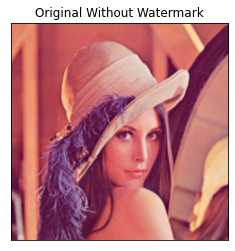

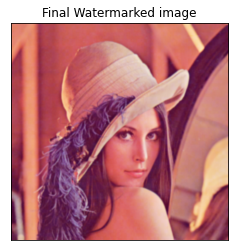

Watermark Exist with NCC 1.00


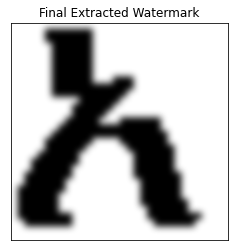

PSNR = 83.58


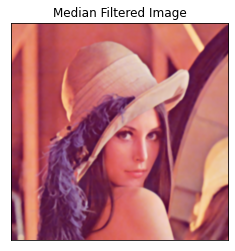

Watermark Exist with NCC 1.00


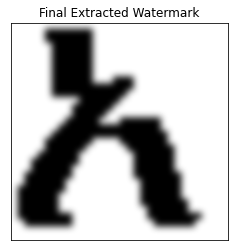

PSNR = 80.99


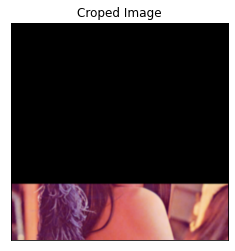

Watermark Exist with NCC 1.00


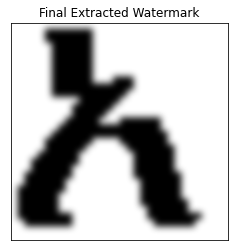

PSNR = 87.09


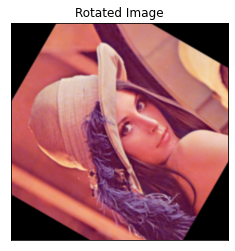

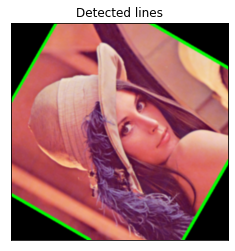

Detected Angle is 60.0231
Watermark Exist with NCC 1.00


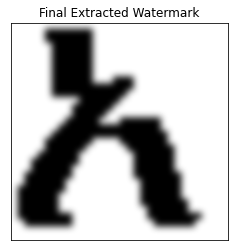

PSNR = 83.13


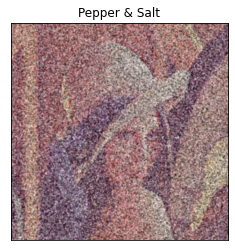

Watermark Exist with NCC 1.00


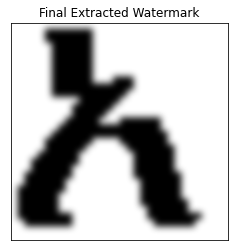

PSNR = 82.13


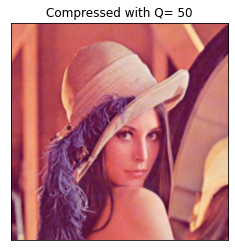

Watermark Exist with NCC 0.85


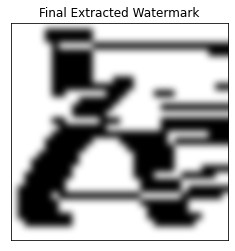

PSNR = 82.85


In [ ]:
#Original = cv2.imread(data_path+"/OriginalImage.jpg", cv2.IMREAD_COLOR)
Original1 = cv2.imread(data_path+"/Lenna_(test_image).png", cv2.IMREAD_COLOR)
Water_mark = cv2.imread(data_path+"/watermark_32x32.jpg", cv2.IMREAD_GRAYSCALE)
r1, BinaryWM =cv2.threshold(Water_mark,127,255,cv2.THRESH_BINARY)

key = np.random.randint(1,1000000000)
Random_img = rand_key(32,32,key)
BinaryWM1= watermark_Xor(BinaryWM,Random_img)

#ret, BinaryWM1 =cv2.threshold(BinaryWM1,127,255,cv2.THRESH_BINARY)
BinaryWM_Orig_D_primed = binarytoGray(BinaryWM1/255) #Passes the normalized image
watermarked = WaterMark_Embedding(Original1,BinaryWM_Orig_D_primed)


W1 = np.zeros(BinaryWM1.shape,dtype=np.uint8)
W2 = np.zeros(BinaryWM1.shape,dtype=np.uint8)
W3 = np.zeros(BinaryWM1.shape,dtype=np.uint8)
W4 = np.zeros(BinaryWM1.shape,dtype=np.uint8)
CheckWatermark(Original1,watermarked,BinaryWM,Random_img)

# Filtering attack
Med_Filtered_img = cv2.medianBlur(watermarked,5)
Gaus_Filtered_img = cv2.GaussianBlur(watermarked,(7,7),0)
Blur_Filtered_img = cv2.blur(watermarked,(5,5))
Bil_Filtered_img = cv2.bilateralFilter(watermarked,9,75,75)
show_image(Med_Filtered_img, "Median Filtered Image")
# show_image(Gaus_Filtered_img, "Gaussian Filtered Image")
# show_image(Blur_Filtered_img, "Blur Filtered Image")
# show_image(Bil_Filtered_img, "BilateralFilter Filtered Image")
CheckWatermark(Original1,Med_Filtered_img,BinaryWM,Random_img)
# CheckWatermark(Original1,Gaus_Filtered_img,BinaryWM,Random_img)
# CheckWatermark(Original1,Blur_Filtered_img,BinaryWM,Random_img)
# CheckWatermark(Original1,Bil_Filtered_img,BinaryWM,Random_img)


#Crop Attack
Im = crop(watermarked,380,512,0,512)
show_image(Im,"Croped Image")
CheckWatermark(Original1,Im,BinaryWM,Random_img)


#Rotation Attack
Im1 = Rotate(watermarked,60) # Theta = [0,180)
show_image(Im1,"Rotated Image")
Rot_angle = estimate_skew_angle(Im1)
Im1 = Rotate(Im1,-1*Rot_angle) 
CheckWatermark(Original1,Im1,BinaryWM,Random_img)

#Pepper and Salt attack
img_s = addsalt_pepper(watermarked, 0.4) 
show_image(img_s,"Pepper & Salt")
CheckWatermark(Original1,img_s,BinaryWM,Random_img)


#Compression Attack
outpath_jpeg = "Compressed_Save.jpg"
jpg_quality=50
Compression(outpath_jpeg,watermarked,jpg_quality)
img = cv2.imread("Compressed_Save.jpg",cv2.IMREAD_COLOR)
msg = f"Compressed with Q= {jpg_quality}"
show_image(img,msg)
CheckWatermark(Original1,img,BinaryWM,Random_img)


In [ ]:
Original1.itemsize

1